In [1]:
import sys
import pathlib
import itertools
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from copairs.map import run_pipeline

sys.path.append("../../")
from src import utils

In [2]:
# parameters
training_singlecell_data = pathlib.Path("../../data/raw/training_data.csv.gz").resolve(
    strict=True
)
neg_control_data = pathlib.Path(
    "../../data/raw/normalized_data/negative_control_data.csv.gz"
).resolve(strict=True)

# output directories
map_out_dir = pathlib.Path("../../data/processed/mAP_scores/")
map_out_dir.mkdir(parents=True, exist_ok=True)

# Loading dataset

Here we are loading the dataset into memory


In [3]:
# loading data
training_sc_data = pd.read_csv(training_singlecell_data).drop("Unnamed: 0", axis=1)

# adding control labels into the dataset
training_sc_data.insert(1, "Metadata_is_control", 0)

# dropping column from training data since it does not exist in the controls
training_sc_data = training_sc_data.drop("Metadata_Object_Outline", axis=1)

## Gather some stats

Here we are gathering some stats about the dataset we are working with.


In [4]:
# print out columns
meta_cols = training_sc_data.columns.tolist()[:14]
pprint(meta_cols)

['Mitocheck_Phenotypic_Class',
 'Metadata_is_control',
 'Cell_UUID',
 'Location_Center_X',
 'Location_Center_Y',
 'Metadata_Plate',
 'Metadata_Well',
 'Metadata_Frame',
 'Metadata_Site',
 'Metadata_Plate_Map_Name',
 'Metadata_DNA',
 'Metadata_Gene',
 'Metadata_Gene_Replicate',
 'CP__AreaShape_Area']


In [5]:
# Count number of single cells per entry in the training dataset
cell_counts_df = (
    training_sc_data.value_counts(["Mitocheck_Phenotypic_Class"])
    .to_frame()
    .reset_index()
)
cell_counts_df.columns = ["label", "n_cells"]

cell_counts_df

,label,n_cells
0,Interphase,420
1,Polylobed,367
2,Prometaphase,345
3,OutOfFocus,304
4,Apoptosis,273
5,Binuclear,184
6,MetaphaseAlignment,175
7,SmallIrregular,164
8,Hole,114
9,Elongated,110


Given the current dataframe, there exists a imbalance among the labels. To address this, we limit our analysis to 54 cells, which allows us to maintain a 1:1 ratio when comparing various individual cells when using copairs in order to mitigate the impact of label imbalances when testing.


## Comparison of all phenotypes


In [6]:
# setting parameters for copairs
pos_sameby = [
    "Mitocheck_Phenotypic_Class",
]
pos_diffby = ["Metadata_Plate", "Metadata_Well"]
neg_sameby = ["Metadata_Plate"]
neg_diffby = ["Mitocheck_Phenotypic_Class"]
null_size = 1000
batch_size = 1000

# setting testing parameters
pheno_labels_combinations = list(
    itertools.combinations(cell_counts_df["label"].tolist(), 2)
)
max_n_cells = 54
seed = 42

In [7]:
calculated_scores = []
for pheno1, pheno2 in pheno_labels_combinations:
    print(f"Comparing {pheno1} and {pheno2}")
    # selecting rows based on phenotype labels and concat
    sel1_df = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == pheno1
    ].sample(n=max_n_cells, random_state=seed)
    sel2_df = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == pheno2
    ].sample(n=max_n_cells, random_state=seed)
    concat_df = pd.concat([sel1_df, sel2_df])

    # now separate metadata and feature space (only CP features for this test)
    print("Separating meta and features data")
    meta, features = utils.split_data(concat_df, dataset="CP")

    # execute copairs pipeline
    print("Executing coapirs pipeline")
    try:
        copairs_result = run_pipeline(
            meta=meta,
            feats=features,
            pos_sameby=pos_sameby,
            pos_diffby=pos_diffby,
            neg_sameby=neg_sameby,
            neg_diffby=neg_diffby,
            batch_size=batch_size,
            null_size=null_size,
        )
    except ZeroDivisionError:
        calculated_scores.append([pheno1, pheno2, 0, 0])

    # grabbing single cells average precision scores
    pheno1_ap_scores = copairs_result.loc[
        copairs_result["Mitocheck_Phenotypic_Class"] == pheno1
    ]["average_precision"].values
    pheno2_ap_scores = copairs_result.loc[
        copairs_result["Mitocheck_Phenotypic_Class"] == pheno2
    ]["average_precision"].values

    # calculate euclidean
    try:
        euclidean_distance = np.linalg.norm(pheno1_ap_scores - pheno2_ap_scores)
    except ValueError:
        cosine_similarities = np.nan

    # Calculate cosine similarity
    vector_a = pheno1_ap_scores.reshape(1, -1)
    vector_b = pheno2_ap_scores.reshape(1, -1)

    try:
        cosine_similarities = cosine_similarity(vector_a, vector_b)[0][0]
    except ValueError:
        cosine_similarities = np.nan

    # store values
    calculated_scores.append([pheno1, pheno2, euclidean_distance, cosine_similarities])

Comparing Interphase and Polylobed
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Comparing Interphase and Prometaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Interphase and OutOfFocus
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing Interphase and Apoptosis
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Interphase and Binuclear
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Interphase and MetaphaseAlignment
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Comparing Interphase and SmallIrregular
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Comparing Interphase and Hole
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Interphase and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Interphase and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing Interphase and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Comparing Interphase and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Comparing Interphase and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Comparing Interphase and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Comparing Interphase and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing Polylobed and Prometaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Polylobed and OutOfFocus
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing Polylobed and Apoptosis
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Polylobed and Binuclear
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Comparing Polylobed and MetaphaseAlignment
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Polylobed and SmallIrregular
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Polylobed and Hole
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Polylobed and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Polylobed and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing Polylobed and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Comparing Polylobed and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Comparing Polylobed and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing Polylobed and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Comparing Polylobed and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Prometaphase and OutOfFocus
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing Prometaphase and Apoptosis
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Prometaphase and Binuclear
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing Prometaphase and MetaphaseAlignment
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Prometaphase and SmallIrregular
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing Prometaphase and Hole
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing Prometaphase and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Comparing Prometaphase and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing Prometaphase and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Prometaphase and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Prometaphase and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing Prometaphase and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Prometaphase and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Comparing OutOfFocus and Apoptosis
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing OutOfFocus and Binuclear
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing OutOfFocus and MetaphaseAlignment
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Comparing OutOfFocus and SmallIrregular
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing OutOfFocus and Hole
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing OutOfFocus and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing OutOfFocus and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

Comparing OutOfFocus and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing OutOfFocus and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Comparing OutOfFocus and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

Comparing OutOfFocus and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing OutOfFocus and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing Apoptosis and Binuclear
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Comparing Apoptosis and MetaphaseAlignment
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Apoptosis and SmallIrregular
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Apoptosis and Hole
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing Apoptosis and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Apoptosis and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Comparing Apoptosis and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Comparing Apoptosis and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Apoptosis and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing Apoptosis and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Apoptosis and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Comparing Binuclear and MetaphaseAlignment
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Binuclear and SmallIrregular
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Binuclear and Hole
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Binuclear and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing Binuclear and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Comparing Binuclear and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Binuclear and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Binuclear and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing Binuclear and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Binuclear and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and SmallIrregular
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and Hole
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Comparing MetaphaseAlignment and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

Comparing SmallIrregular and Hole
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Comparing SmallIrregular and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing SmallIrregular and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Comparing SmallIrregular and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing SmallIrregular and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Comparing SmallIrregular and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing SmallIrregular and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing SmallIrregular and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Hole and Elongated
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Hole and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Comparing Hole and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Hole and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing Hole and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

Comparing Hole and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Hole and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Elongated and ADCCM
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

Comparing Elongated and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Comparing Elongated and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Comparing Elongated and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

Comparing Elongated and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Elongated and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Comparing ADCCM and Anaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing ADCCM and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing ADCCM and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

Comparing ADCCM and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing ADCCM and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing Anaphase and Large
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Comparing Anaphase and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing Anaphase and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Comparing Anaphase and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Comparing Large and Grape
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing Large and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Comparing Large and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Comparing Grape and Metaphase
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Comparing Grape and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/2 [00:00<?, ?it/s]

Comparing Metaphase and Folded
Separating meta and features data
Executing coapirs pipeline


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [8]:
scores_df = pd.DataFrame(
    calculated_scores,
    columns=["Pheno1", "Pheno2", "euclidean_distance", "cosine_similaritie"],
)
scores_df

,Pheno1,Pheno2,euclidean_distance,cosine_similaritie
0,Interphase,Polylobed,0.287298,0.999305
1,Interphase,Prometaphase,0.408705,0.998506
2,Interphase,OutOfFocus,0.016718,0.999997
3,Interphase,Apoptosis,0.443980,0.998320
4,Interphase,Binuclear,0.272739,0.999345
...,...,...,...,...
131,Large,Folded,0.046917,0.999980
132,Grape,Metaphase,0.060116,0.999982
133,Grape,Folded,0.000000,0.000000
134,Grape,Folded,0.060116,NaN


**About scores**: Cosine Similarity ranges from 0 to 1, with 1 indicating perfect similarity and 0 indicating perfect dissimilarity, while Euclidean Distance ranges from 0 to positive values, with 0 indicating perfect similarity and larger values indicating greater dissimilarity.


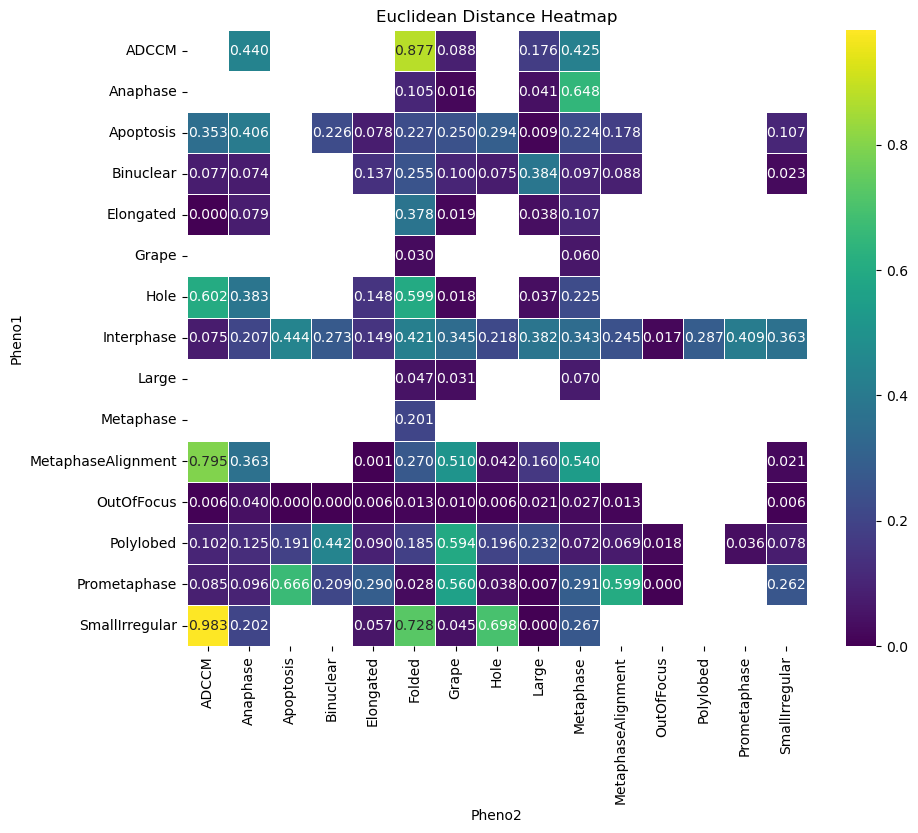

In [9]:
# Pivot the DataFrame to create a matrix for heatmap
heatmap_data = scores_df.pivot_table(
    index="Pheno1", columns="Pheno2", values="euclidean_distance"
)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".3f", linewidths=0.5)
plt.title("Euclidean Distance Heatmap")
plt.show()

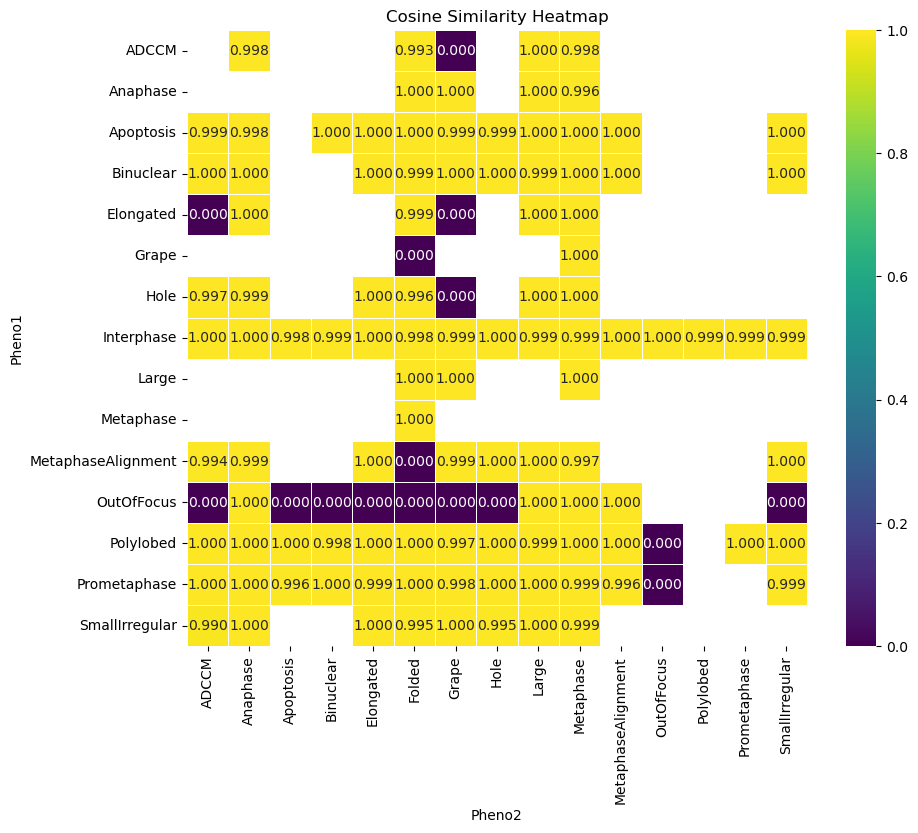

In [10]:
heatmap_data = scores_df.pivot_table(
    index="Pheno1", columns="Pheno2", values="cosine_similaritie"
)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".3f", linewidths=0.5)
plt.title("Cosine Similarity Heatmap")
plt.show()